In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx, from_networkx

In [2]:
dataset = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(data)

Dataset: CSL(150):
Number of graphs: 150
Number of features: 0
Number of classes: 10
Data(edge_index=[2, 164], y=[1], num_nodes=41)


In [3]:
import torch_geometric
import copy
from typing import List, Tuple
from torch_geometric.data import Batch, Data
from torch_geometric.data.collate import collate
from torch_geometric.data.data import BaseData
from torch_geometric.data.dataset import Dataset, IndexType
from torch_geometric.data.separate import separate
from torch_geometric.io import fs
from torch import from_numpy, mean, svd, lt, diag, t
import torch
from tqdm import tqdm

class GMixupDataset():
    r"""A wrapper class around a dataset that applies G-Mixup data augmentation to its base dataset.

    Args:
        base_dataset (Dataset): The dataset to apply G-Mixup to.
        log (bool, optional): Whether to print any console output while processing the dataset. (default: :obj:`True`)
        align_graphs (bool, optional): Whether to align the graphs by node degree before generating graphons. (default: :obj:`True`)
        threshold (float, optional): The threshold to use for singular value thresholding. (default: :obj:`2.02`)
        generate_graphons (bool, optional): Whether to generate graphons for the dataset during initialization or on-the-fly. Note that generating graphons for the dataset during initialization can be slow for large datasets. (default: :obj:`True`)
        ample_num (int, optional): How many graphs to sample from a class when approximating graphon for that class. Default value of -1 means to use all available graphs from that class. (default: :obj:`-1`)
    """

    def __init__(
        self,
        base_dataset: Dataset,
        log: bool = True,
        align_graphs: bool = True,
        threshold: float = 2.02,
        generate_graphons: bool = True,
        sample_num: int =-1,
    ) -> None:
        self.base_dataset = base_dataset
        self.log = log
        self.align_graphs = align_graphs
        self.threshold = threshold
        self.sample_num = sample_num
        
        self.graphs_by_class = [np.empty(0, dtype=int) for _ in range(self.base_dataset.num_classes)]
        for i, data in enumerate(self.base_dataset):
            label = data.y.item()
            self.graphs_by_class[label] = np.append(self.graphs_by_class[label], i)
            
        self.max_node_count = int(np.max([data.num_nodes for data in self.base_dataset]))
        self.graphons = np.zeros((self.base_dataset.num_classes, self.max_node_count, self.max_node_count))
        self.graphons_generated = torch.zeros(self.base_dataset.num_classes, dtype=torch.bool)
        
        if generate_graphons:
            self.generate_graphons()
        else:
            if self.log:
                print(f"Graphons not generated during initialization. Graphons will be generated on-the-fly, or you can call generate_graphons() to generate them all at once.\n")
        
    def generate_graphons(self) -> None:
        if self.log:
            print(f"Generating graphons for {self.base_dataset.num_classes} classes...\n")
        
        for i in range(self.base_dataset.num_classes):
            if self.graphons_generated[i]:
                if self.log:
                    print(f"Graphon for class {i} already generated, skipping...")
                continue
            else:
                self.generate_graphon(i)
        
        return None
    
    def align_graphs_by_degree(self, graph_adjs:List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray], int, int] :
        num_nodes = [graph_adj.shape[0] for graph_adj in graph_adjs]
        max_num = max(num_nodes)
        min_num = min(num_nodes)

        aligned_adjs = []
        normalized_node_degrees = []
        for graph_adj in graph_adjs :
            curr_n = graph_adj.shape[0]
            node_degree = 0.5 * np.sum(graph_adj, axis=0) + 0.5 * np.sum(graph_adj, axis=1)
            node_degree /= np.sum(node_degree)
            perm = np.argsort(node_degree)  # ascending
            perm = perm[::-1]  # descending

            sorted_node_degree = node_degree[perm]
            sorted_node_degree = sorted_node_degree.reshape(-1, 1)

            sorted_graph = copy.deepcopy(graph_adj)
            sorted_graph = sorted_graph[perm, :]
            sorted_graph = sorted_graph[:, perm]

            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:curr_n, :] = sorted_node_degree
            aligned_adj = np.zeros((max_num, max_num))
            aligned_adj[:curr_n, :curr_n] = sorted_graph
            normalized_node_degrees.append(normalized_node_degree)
            aligned_adjs.append(aligned_adj)
        return aligned_adjs, normalized_node_degrees, max_num, min_num

    def generate_graphon(self, class_idx: int) -> np.ndarray :
        if self.graphons_generated[class_idx]:
            if self.log:
                print(f"Graphon for class {class_idx} already generated, skipping...")
            return self.graphons[class_idx]
        
        num_graphs_of_class = len(self.graphs_by_class[class_idx])
        if self.sample_num > 0 and num_graphs_of_class > self.sample_num :
            class_sample = np.random.choice(self.graphs_by_class[class_idx], self.sample_num, replace=False)
        else :
            class_sample = self.graphs_by_class[class_idx]
        class_adj_mats = [nx.to_numpy_array(to_networkx(self.base_dataset[graph_index])) 
                          for graph_index in class_sample]
        
        if self.align_graphs:
            aligned_graphs, normalized_node_degrees, max_num, min_num = self.align_graphs_by_degree(class_adj_mats)
            class_adj_mats = aligned_graphs
        
        graph_tensor_np = np.array(class_adj_mats)
        graph_tensor = from_numpy(graph_tensor_np).float()
        
        if self.log:
            print(f"Generating graphon for class {class_idx} with {graph_tensor.size(0)} graphs...")
        
        # TODO: i believe this breaks when each graph has different number of nodes
        # we could potentially offer this as a speedup option to the user if we pad the adjacency matrices        
        # # collapse adj mats into 1 matrix
        # if graph_tensor.size(0) > 1 :
        #     agg_graph_adj = mean(graph_tensor, dim=0)
        # else :
        #     agg_graph_adj = graph_tensor[0, :, :]
        
        final_graphon = None
        count = 0
        for agg_graph_adj in tqdm(graph_tensor):
            # normalize adjacency matrix to be in interval [-1, 1]
            agg_graph_adj_normalized = 2 * agg_graph_adj - 1

            # svd graphon estimation \cite{Chatterjee}
            U, S, Vh = torch.linalg.svd(agg_graph_adj_normalized)

            num_nodes = agg_graph_adj.size(0)
            num_edges = torch.sum(agg_graph_adj == 1)
            proportion_edges = num_edges / (num_nodes ** 2) / 2

            scaled_thresh = self.threshold * ((num_nodes * proportion_edges) ** 0.5)
            S[lt(S, scaled_thresh)] = 0

            graphon = U @ diag(S) @ Vh

            graphon[graphon >= 1] = 1 # clip
            graphon[graphon <= -1] = -1 # clip
            graphon = (graphon + 1) / 2 # renormalize graphon to be in interval [0, 1]
            graphon = torch.nn.functional.interpolate(graphon.unsqueeze(0).unsqueeze(0), size=(self.max_node_count, self.max_node_count), mode='bilinear', align_corners=False).squeeze()

            if final_graphon is None:
                final_graphon = graphon
            else:
                final_graphon = (final_graphon * count + graphon) / (count + 1)
            count += 1

        self.graphons[class_idx] = final_graphon.numpy()
        self.graphons_generated[class_idx] = True
        
        if self.log:
            print(f"Graphon for class {class_idx} generated.")
            print(f"graphon avg = {torch.mean(final_graphon)}, original avg = {torch.mean(graph_tensor)}. These should be close.\n")
        
        return graphon.numpy()
  
    # TODO: check how IndexType works in torch_geometric    
    def generate_graphs(self, idx_1: int, idx_2: int, mixing_param: float = 0.5, K: int = 10, method: str = 'random', size: int = 1) -> Batch:
        # ) -> 'Dataset':
        r"""Takes in a batch of graph label pairs and a mixing parameter λ, and returns the new synthetic graph(s) generated using G-Mixup
        
        Args:
            idx_1 (int): Index of the first graph in the pair
            idx_2 (int): Index of the second graph in the pair
            mixing_param (float): The mixing parameter λ
            K (int): The number of nodes in the output synthetic graph(s)
            method (str): The method to use for generating the synthetic graph(s). Options are 'random' and 'uniform'. (default: :obj:`'random'`)
            size (int): The number of synthetic graphs to generate. (default: :obj:`1`)
        """
        if not self.graphons_generated[idx_1]:
            if self.log:
                print(f"Graphon for class {idx_1} not yet generated, generating...")
            self.generate_graphon(idx_1)
        if not self.graphons_generated[idx_2]:
            if self.log:
                print(f"Graphon for class {idx_2} not yet generated, generating...")
            self.generate_graphon(idx_2)
        
        if self.log:
            print(f"Generating {size} synthetic graph(s) for indices {idx_1} and {idx_2} with mixing parameter {mixing_param} and {K} nodes...")
        
        graphs = None
        for i in range(size):
            graph = self.generate_graph(idx_1, idx_2, mixing_param, K, method)
            if i == 0:
                graphs = graph
            else:
                graphs = torch.cat((graphs, graph), dim=0)
        
        return graphs
                
    def generate_graph(self, idx_1: int, idx_2: int, mixing_param: float = 0.5, K: int = 10, method: str = 'random') -> Data:
        graphon1 = self.graphons[idx_1]
        graphon2 = self.graphons[idx_2]
        mixed_graphon = mixing_param * graphon1 + (1 - mixing_param) * graphon2
        
        u_values = None
        u_values_index = None
        if method == 'random':
            u_values = np.random.uniform(0, 1, K)
            u_values.sort()
            u_values_index = (u_values * mixed_graphon.shape[0]).astype(int)
        elif method == 'uniform':
            u_values = np.linspace(0, 1, K, endpoint=False) # DEBUGGING: use this to reconstruct without RNG, should reconstruct nearly the same graph if there is no thresholding
            u_values_index = (u_values * mixed_graphon.shape[0]).astype(int)
        else:
            raise ValueError('Invalid method')
                    
        adjacency_matrix = np.zeros((K, K))
        for i in range(K):
            for j in range(K):
                p = mixed_graphon[u_values_index[i], u_values_index[j]]
                if np.random.rand() < p:
                    adjacency_matrix[i, j] = 1
                    # adjacency_matrix[j, i] = 1
                
        # graph = nx.from_numpy_array(adjacency_matrix)
        graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
        graph_pyg = from_networkx(graph)
        
        if self.log:
            print(f"Synthetic graph(s) generated.\n")
        
        return graph_pyg
    
    def __getattr__(self, name: str):
        if name in self.__dict__:
            return getattr(self, name)
        else:
            return getattr(self.base_dataset, name)

In [4]:
gnn_benchmark = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')
gmixup_gnn_benchmark = GMixupDataset(gnn_benchmark)

Generating graphons for 10 classes...

Generating graphon for class 0 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3081.93it/s]


Graphon for class 0 generated.
graphon avg = 0.11567791551351547, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 1 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3106.89it/s]


Graphon for class 1 generated.
graphon avg = 0.11144312471151352, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 2 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3718.35it/s]


Graphon for class 2 generated.
graphon avg = 0.12372516840696335, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 3 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3498.17it/s]


Graphon for class 3 generated.
graphon avg = 0.12302249670028687, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 4 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3854.82it/s]


Graphon for class 4 generated.
graphon avg = 0.1266970932483673, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 5 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3846.10it/s]


Graphon for class 5 generated.
graphon avg = 0.12481062114238739, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 6 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3682.88it/s]


Graphon for class 6 generated.
graphon avg = 0.12500157952308655, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 7 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3988.50it/s]


Graphon for class 7 generated.
graphon avg = 0.11931084096431732, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 8 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3849.16it/s]


Graphon for class 8 generated.
graphon avg = 0.12836943566799164, original avg = 0.09756097197532654. These should be close.

Generating graphon for class 9 with 15 graphs...


100%|██████████| 15/15 [00:00<00:00, 3750.94it/s]

Graphon for class 9 generated.
graphon avg = 0.1259157806634903, original avg = 0.09756097197532654. These should be close.



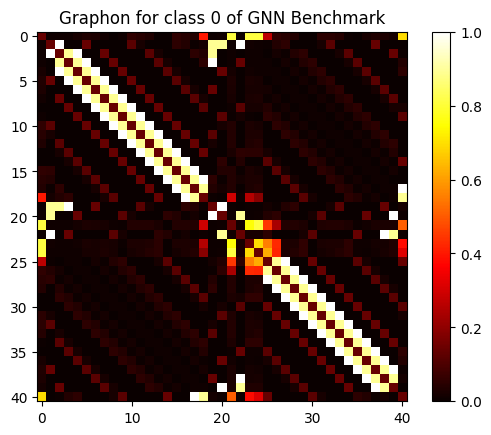

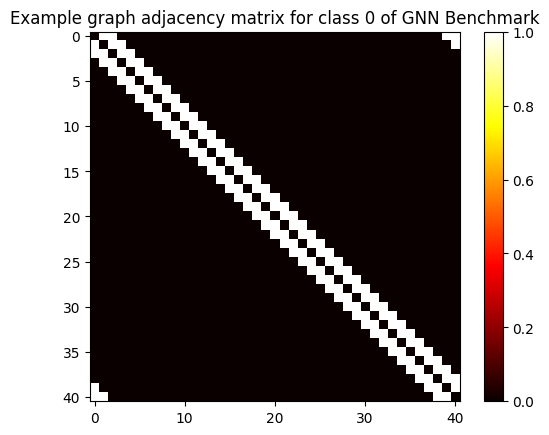

In [5]:
import matplotlib.pyplot as plt
plt.imshow(gmixup_gnn_benchmark.graphons[0], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 0 of GNN Benchmark")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[0][0]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 0 of GNN Benchmark")
plt.show()

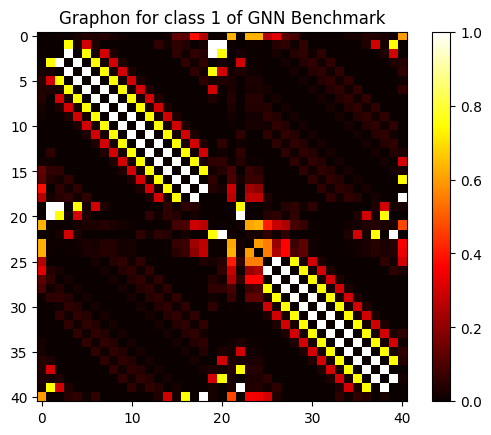

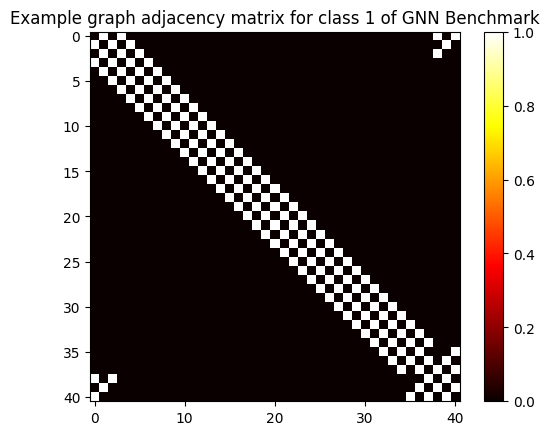

In [6]:
plt.imshow(gmixup_gnn_benchmark.graphons[1], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 1 of GNN Benchmark")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[1][5]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 1 of GNN Benchmark")
plt.show()

Generating 1 synthetic graph(s) for indices 0 and 0 with mixing parameter 0 and 41 nodes...
Synthetic graph(s) generated.

DiGraph with 41 nodes and 164 edges
graph real average degree:  4.0
Drawing Real Label 0 graph...
DiGraph with 41 nodes and 201 edges
graph gen average degree:  4.902439024390244
Drawing Generated Label 0 graph...


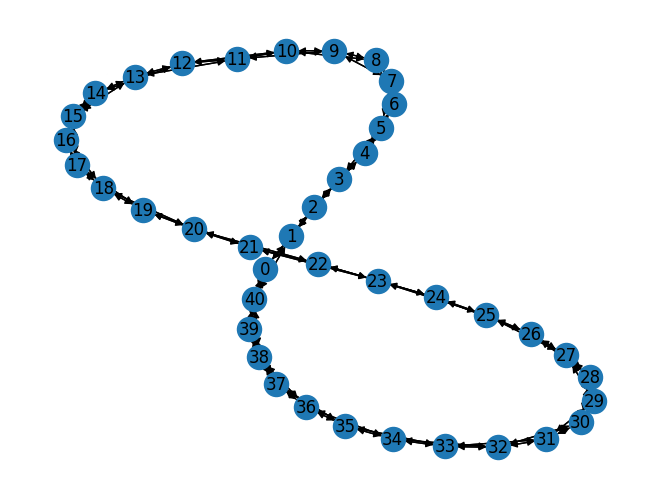

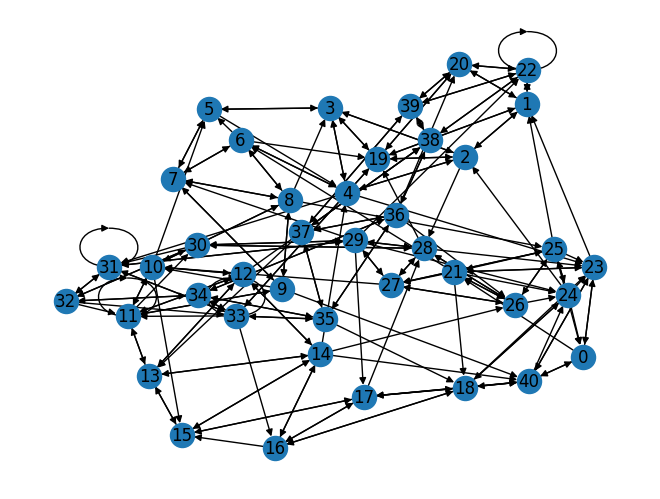

In [7]:
graph_real = to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[0][0]])
graph_gen = to_networkx(gmixup_gnn_benchmark.generate_graphs(0, 0, 0, K=41, method='uniform'))
# graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 1, 1)


import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values()))/2)
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values()))/2)
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

Generating 1 synthetic graph(s) for indices 1 and 1 with mixing parameter 0 and 41 nodes...
Synthetic graph(s) generated.

DiGraph with 41 nodes and 164 edges
graph real average degree:  4.0
Drawing Real Label 1 graph...
DiGraph with 41 nodes and 175 edges
graph gen average degree:  4.2682926829268295
Drawing Generated Label 1 graph...


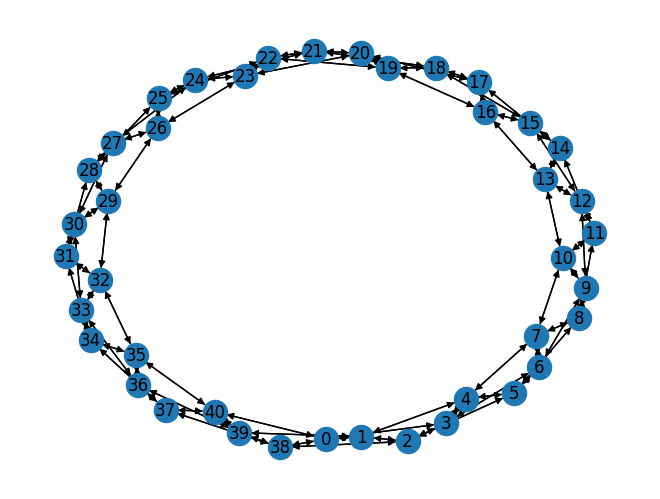

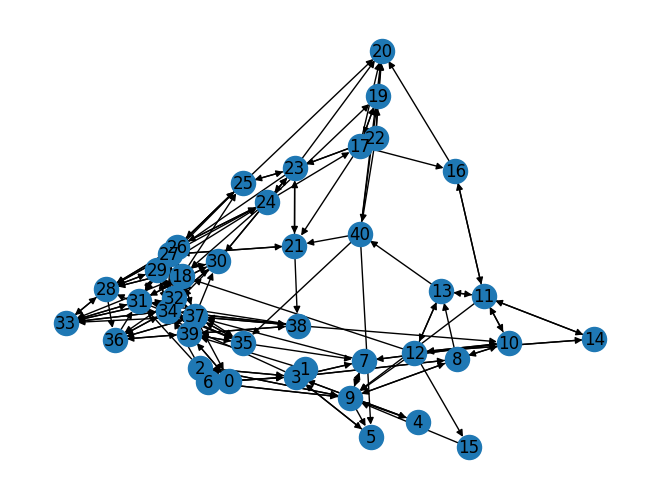

In [8]:
graph_real = to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[1][5]])
graph_gen = to_networkx(gmixup_gnn_benchmark.generate_graphs(1, 1, 0, K=41, method='random'))
# graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 1, 1)


import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values()))/2)
print("Drawing Real Label 1 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values()))/2)
print("Drawing Generated Label 1 graph...")
nx.draw(graph_gen, with_labels=True)

In [9]:
mnist = torch_geometric.datasets.MNISTSuperpixels(root="tmp/mnist")


In [10]:
gmixup_mnist = GMixupDataset(mnist, log=True, generate_graphons=False, sample_num=20)

Graphons not generated during initialization. Graphons will be generated on-the-fly, or you can call generate_graphons() to generate them all at once.



In [11]:
gmixup_mnist.graphs_by_class[0]

array([    1,    21,    34, ..., 59952, 59972, 59987])

Graphon for class 0 not yet generated, generating...
Generating graphon for class 0 with 20 graphs...


100%|██████████| 20/20 [00:00<00:00, 1644.89it/s]

Graphon for class 0 generated.
graphon avg = 0.25724124908447266, original avg = 0.2345244437456131. These should be close.

Generating 1 synthetic graph(s) for indices 0 and 0 with mixing parameter 0 and 75 nodes...
Synthetic graph(s) generated.

DiGraph with 75 nodes and 1260 edges
graph real average degree:  33.6
Drawing Real Label 0 graph...


DiGraph with 75 nodes and 1546 edges
graph gen average degree:  41.22666666666667
Drawing Generated Label 0 graph...


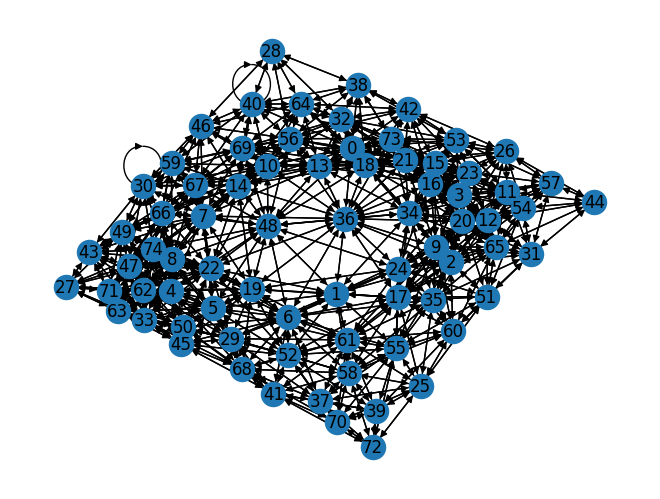

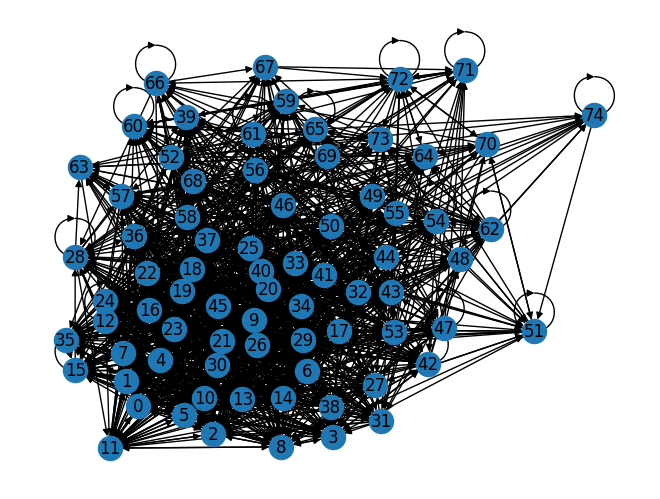

In [12]:
graph_real = to_networkx(gmixup_mnist.base_dataset[gmixup_mnist.graphs_by_class[0][0]])
graph_gen = to_networkx(gmixup_mnist.generate_graphs(0, 0, 0, K=75))

import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values())))
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values())))
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

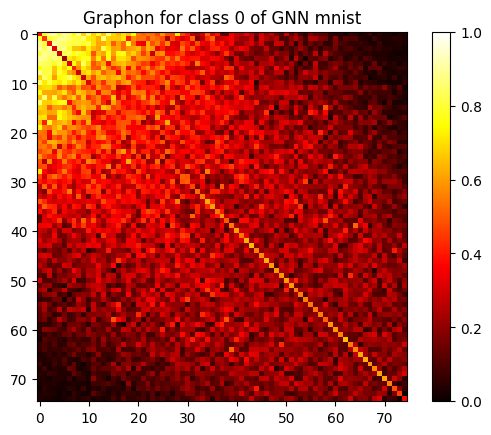

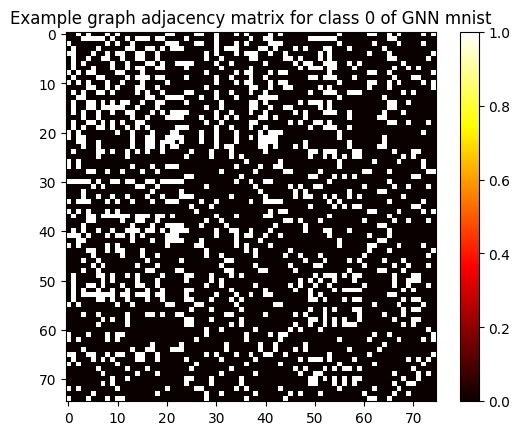

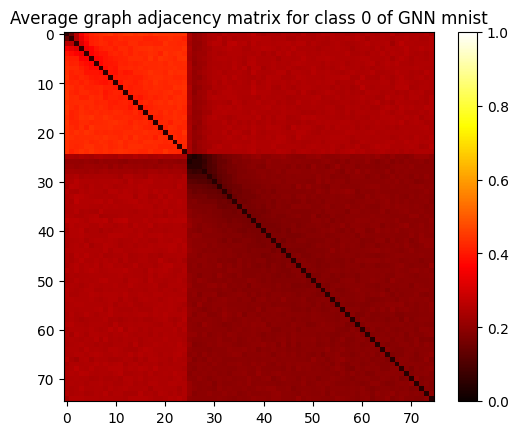

In [13]:
plt.imshow(gmixup_mnist.graphons[0], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 0 of GNN mnist")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(gmixup_mnist.base_dataset[gmixup_mnist.graphs_by_class[0][5]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 0 of GNN mnist")
plt.show()

g0_avg_adj = np.mean([nx.to_numpy_array(to_networkx(gmixup_mnist.base_dataset[graph_index])) for graph_index in gmixup_mnist.graphs_by_class[0]], axis=0)
plt.imshow(g0_avg_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Average graph adjacency matrix for class 0 of GNN mnist")
plt.show()

# Adding GMixup to a GCN for graph classification on REDDIT-BINARY dataset

In [14]:
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

In [15]:
def add_dummy_feature(data):
    # If data.x does not exist or data.num_features == 0, create a dummy feature
    if data.x is None or data.num_node_features == 0:
        data.x = torch.ones((data.num_nodes, 1), dtype=torch.float)
    return data

reddit_base = TUDataset(root='data', name='REDDIT-BINARY', transform=add_dummy_feature)

In [16]:
reddit_mixed = GMixupDataset(reddit_base, sample_num=10)

Generating graphons for 2 classes...

Generating graphon for class 0 with 10 graphs...


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Graphon for class 0 generated.
graphon avg = 0.0003030969819519669, original avg = 0.0002813815954141319. These should be close.

Generating graphon for class 1 with 10 graphs...


100%|██████████| 10/10 [00:00<00:00, 17.05it/s]

Graphon for class 1 generated.
graphon avg = 0.000994057976640761, original avg = 0.0008465218124911189. These should be close.



observe some characteristics of the two classes

In [17]:
print(f"Class 0:")
print(f"   degrees:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[0][i]])
    print(f"      {sorted(list(dict(g.degree()).values()), reverse=True)}")
print(f"   num_nodes:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[0][i]])
    print(f"      {len(list(dict(g.degree()).values()))}")


print(f"Class 1:")
print(f"   degrees:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][i]])
    print(f"      {sorted(list(dict(g.degree()).values()), reverse=True)}")
print(f"   num_nodes:")
for i in range(10) :
    g = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][i]])
    print(f"      {len(list(dict(g.degree()).values()))}")

Class 0:
   degrees:
      [498, 50, 40, 38, 36, 36, 26, 22, 20, 16, 16, 16, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [18]:
reddit_mixed.graphons[0]

array([[1.03414061e-06, 2.79892355e-01, 7.65258551e-01, ...,
        8.54564756e-02, 3.13365608e-02, 1.28558284e-04],
       [2.81039834e-01, 3.86102974e-01, 5.68295538e-01, ...,
        5.87818809e-02, 2.15687770e-02, 1.09997716e-04],
       [7.68396020e-01, 5.70285380e-01, 2.26737142e-01, ...,
        1.25248488e-02, 4.63021686e-03, 7.78114554e-05],
       ...,
       [8.53840262e-02, 5.87284639e-02, 1.25043988e-02, ...,
        7.57850671e-07, 7.61078240e-07, 7.62939464e-07],
       [3.12626362e-02, 2.15121601e-02, 4.60362993e-03, ...,
        7.57850671e-07, 7.61078240e-07, 7.62939464e-07],
       [5.37663691e-05, 5.15421561e-05, 4.76850910e-05, ...,
        7.57850671e-07, 7.61078240e-07, 7.62939464e-07]])

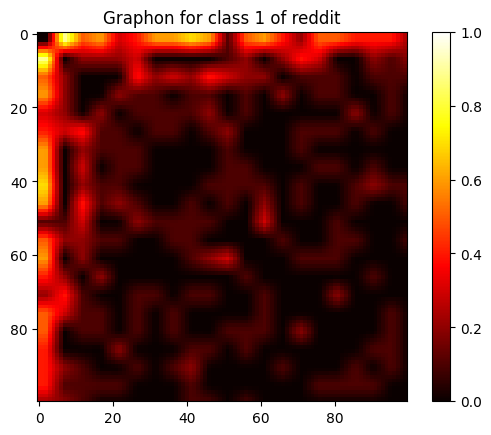

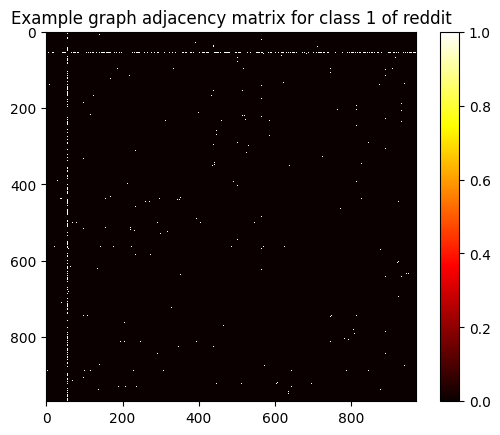

In [19]:
plt.imshow(reddit_mixed.graphons[1][:100, :100], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Graphon for class 1 of reddit")
plt.show()

g0_adj = nx.to_numpy_array(to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][5]]))
plt.imshow(g0_adj, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title("Example graph adjacency matrix for class 1 of reddit")
plt.show()

Generating 1 synthetic graph(s) for indices 1 and 1 with mixing parameter 0 and 218 nodes...
Synthetic graph(s) generated.

DiGraph with 218 nodes and 480 edges
graph real degrees:  [256, 26, 26, 24, 22, 12, 12, 12, 10, 10, 10, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Drawing Real Label 0 graph...
DiGraph with 218 nodes and 93 edges
graph gen degrees:  [57, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

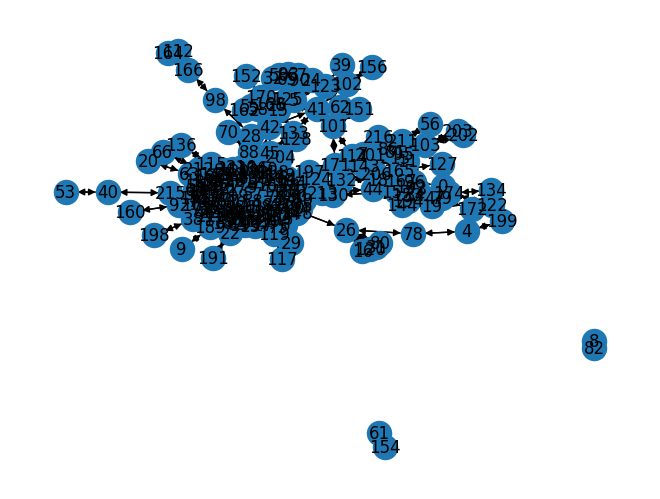

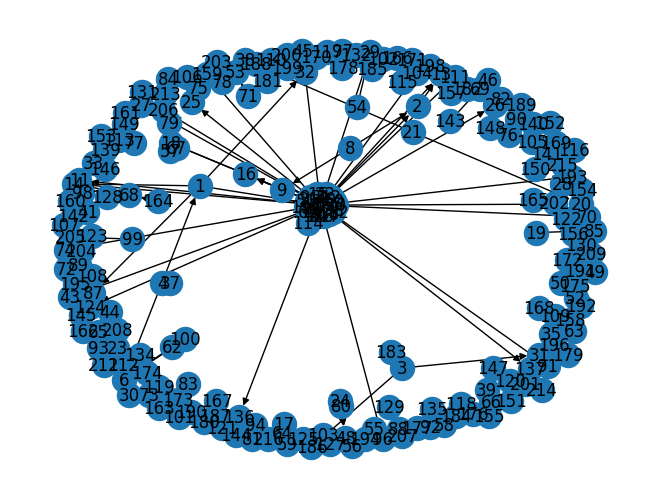

In [20]:
graph_real = to_networkx(reddit_mixed.base_dataset[reddit_mixed.graphs_by_class[1][0]])
graph_gen = to_networkx(reddit_mixed.generate_graphs(1, 1, 0, K=218, method='uniform'))

print(graph_real)
print("graph real degrees: ", sorted(list(dict(graph_real.degree()).values()), reverse=True))
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen degrees: ", sorted(list(dict(graph_gen.degree()).values()), reverse=True))
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

train baseline gcn on reddit binary data for comparison

In [21]:
import random

In [22]:
# dataset = list(reddit_base)
dataset = reddit_base
# random.shuffle(dataset)
train_num = int(len(dataset) * 0.5)
train_dataset = dataset[:train_num]
val_dataset = dataset[train_num:]

train_loader = torch_geometric.loader.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch_geometric.loader.DataLoader(val_dataset, batch_size=32)

In [23]:
dataset.num_node_features

1

In [24]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_mean_pool
import torch.nn.functional as F

class MyGIN(torch.nn.Module) :
    def __init__(self, in_channels=1, num_hidden=32, num_classes=1):
        super(MyGIN, self).__init__()

        nn1 = Sequential(Linear(in_channels, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(num_hidden)

        nn2 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(num_hidden)

        nn3 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(num_hidden)

        nn4 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(num_hidden)

        nn5 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(num_hidden)

        self.fc1 = Linear(num_hidden, num_hidden)
        self.fc2 = Linear(num_hidden, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        # x = global_add_pool(x, batch)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [25]:
model = MyGIN(in_channels=dataset.num_node_features, num_hidden=32, num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

def train(model, train_loader):
    model.train()
    for data in train_loader:
        # print( "data.y", data.y )
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        y = data.y.view(-1, 1)
        print(output, y, sep='\n')
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
    return model

def validate(model, val_loader) :
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for data in val_loader :
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        y = data.y.view(-1, 1)
        print(pred, y, sep="\n\n")
        loss += loss_fn(output, y).item() * data.num_graphs
        y = y.max(dim=1)[1]
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
    acc = correct / total
    loss = loss / total
    return acc, loss


In [27]:
for i in range(10) : # epochs
    model = train(model, train_loader)
    accuracy, loss = validate(model, val_loader)
    print(f"Epoch {i}: accuracy={accuracy}, loss={loss}")
    

/var/folders/61/jy1h8jns4t39ggk5639b7cs00000gn/T/ipykernel_71086/645803624.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 0: accuracy=1.0, loss=0.0
Epoch 1: accuracy=1.0, loss=0.0
Epoch 2: accuracy=1.0, loss=0.0
Epoch 3: accuracy=1.0, loss=0.0
Epoch 4: accuracy=1.0, loss=0.0
Epoch 5: accuracy=1.0, loss=0.0
Epoch 6: accuracy=1.0, loss=0.0
Epoch 7: accuracy=1.0, loss=0.0
Epoch 8: accuracy=1.0, loss=0.0
Epoch 9: accuracy=1.0, loss=0.0
